MM performance and regional weights

In [1]:
import pandas as pd
import numpy as np

phenotype = 'group'
denoise = "simple+gsr"
resample_list = [0]

# load results
in_path = '../results/model_performance/'
in_dfs = {'accuracy': [], 'roc': [], 'confounders': []}
for model in ["multilayer_metamatch"]:
    for resample in resample_list:
        if resample != 0:
            in_file = f"model-{model}_phenotype-{phenotype}_denoise-{denoise}_N{resample}.csv"
        else:
            in_file = f"model-{model}_phenotype-{phenotype}_denoise-{denoise}.csv"

        for i in ['accuracy', 'roc']:
            _df = pd.read_csv(in_path+i+'_'+in_file)
            _df['resample'] = resample
            in_dfs[i].append(_df)

        if resample == 0:
            i = 'confounders'
            _df = pd.read_csv(in_path+i+'_'+in_file)
            _df['resample'] = resample
            in_dfs[i].append(_df)

accuracy_df = pd.concat(in_dfs['accuracy'], axis=0, ignore_index=True)
roc_df = pd.concat(in_dfs['roc'], axis=0, ignore_index=True)
confounders_df = pd.concat(in_dfs['confounders'], axis=0, ignore_index=True)

## Statistics

### Comparison to permutations and basic model performance
Generally using median rather than means.

In [2]:
import pingouin as pg 

# Comparison between full models and null (percentiles)
models = ['multilayer_metamatch_site_confounds_removed']

stats_result = pd.DataFrame(columns=['Meta-match'])

print("Percentile compared to shuffled models:")
for meas in ['acc', 'roc_auc']:
    print(meas)
    for model in models:
        print(model)
        df = accuracy_df.loc[(accuracy_df.model == model)
                            & (accuracy_df["resample"] == 0)]
        value = df.loc[df.permuted == False, meas].median()
        null_distribution = df.loc[df.permuted == True, meas].values 
        percentile = (null_distribution < value).mean()
        p_val = (0.5 - (abs(percentile - 0.5))) # Express similar to a p value regardless of direction
        print('\t', percentile, 'p=', p_val.round(4))
        print(df.loc[df.permuted == True, meas].median()) # check it is 50% for BACC

        # Thomas's resampled t-test
        #mu, tval, p = CBIG_corrected_resampled_ttest(df.loc[df.permuted == False, meas].values, 1/4, 0.5)
        #print("Resampled p=",p.round(2))

for model in models:
    print(model)
    for meas in ['acc', 'roc_auc', 'sensitivity', 'specificity']:
        value = accuracy_df.loc[(accuracy_df.model == model)
                            & (accuracy_df["resample"] == 0)
                            & (accuracy_df.permuted == False), meas].median()
        print('\t',meas,round(value,2))

print('% Median difference in raw performance')
meas = 'acc'
data = accuracy_df.loc[(accuracy_df.model == 'logreg_site_confounds_removed')
                        & (accuracy_df["resample"] == 0)
                        & (accuracy_df["permuted"] == False),
                        meas].median()
data2 = accuracy_df.loc[(accuracy_df.model == 'multilayer_metamatch_site_confounds_removed')
                        & (accuracy_df["resample"] == 0)
                        & (accuracy_df["permuted"] == False),
                        meas].median()
print("mm =", round(data2, 4)*100)
        

Percentile compared to shuffled models:
acc
multilayer_metamatch_site_confounds_removed
	 0.997 p= 0.003
0.5
roc_auc
multilayer_metamatch_site_confounds_removed
	 0.997 p= 0.003
0.4879195330414843
multilayer_metamatch_site_confounds_removed
	 acc 0.61
	 roc_auc 0.7
	 sensitivity 0.77
	 specificity 0.46
% Median difference in raw performance
mm = 61.07


/home/lukeh/miniconda3/envs/MetaMatch/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## Brain imaging weights
Brain images are created in the brain_features notebook

In [3]:
import pickle
n_rot = 10000
model_suffix = '_site_confounds_removed'
model = "multilayer_metamatch"
infile = f"../results/whole_brain_features/phenotype-{phenotype}_denoise-{denoise}_model-{model}{model_suffix}_Nrot-{n_rot}_"

with open(infile+"weighted_degree.pickle", 'rb') as handle:
    weighted_degree = pickle.load(handle)

plot_data_arrays = np.zeros((454))
plot_data_arrays[54::] = weighted_degree[model][0:400].copy()


In [4]:
n_rot = 10000

model = "multilayer_metamatch"
infile = f"../results/whole_brain_features/phenotype-{phenotype}_denoise-{denoise}_model-{model}{model_suffix}_Nrot-{n_rot}_"
net_df = pd.read_csv(infile+'network_results.csv')
net_df.head()

,Unnamed: 0,network,model,permutation,iteration,value
0,0,Vis,multilayer_metamatch,False,0,0.001125
1,0,Vis,multilayer_metamatch,False,1,0.002375
2,0,Vis,multilayer_metamatch,False,2,-0.000236
3,0,Vis,multilayer_metamatch,False,3,0.001781
4,0,Vis,multilayer_metamatch,False,4,0.000523


## Plots

In [5]:
def get_cropped_img(img,
                    x_start_buffer=10,
                    x_finish_buffer=10,
                    y_start_buffer=10,
                    y_finish_buffer=10,
                    ):
    # Returns a cropped input image

    # average across color information (3rd dimension)
    m_img = np.mean(img, axis=2)

    x_start = (np.where(np.argmax(m_img != np.max(img), axis=0))[0][0] ) - x_start_buffer
    x_finish = (np.where(np.argmax(m_img != np.max(img), axis=0))[0][-1]) + x_finish_buffer
    y_start = np.where(np.argmax(m_img != np.max(img), axis=1))[0][0] - y_start_buffer
    y_finish = np.where(np.argmax(m_img != np.max(img), axis=1))[0][-1] + y_finish_buffer

    # Crop the input image based on determined crop heights and widths
    img_cropped = img[y_start:y_finish, x_start:x_finish, :]
    return img_cropped

/tmp/ipykernel_2368765/1296554934.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['acc_fmt'] = df.acc.values * 100
/tmp/ipykernel_2368765/1296554934.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['model'].replace('multilayer_metamatch_site_confounds_removed',


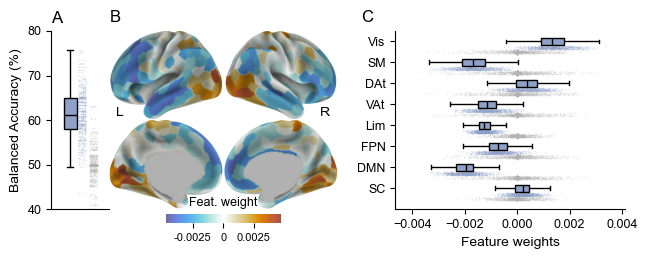

In [31]:
import matplotlib.gridspec as gridspec
import matplotlib.ticker as tkr
import matplotlib.pyplot as plt
import seaborn as sns
import cmasher as cmr
import matplotlib as mpl
# params
pal = [sns.color_palette("Set2")[2], sns.color_palette("Set2")[7]]
location = 'Cortex'  # Subcortex or Cortex
lims=(-0.0042, 0.0042)
plt.rcParams["font.family"] = "Arial"
plt.rcParams['svg.fonttype'] = 'none'

# figure
fig = plt.figure(figsize=(7.4, 2.5))

# create 1st gridspec main plots + colorbars
gs = gridspec.GridSpec(2, 1, height_ratios=(0.95, 0.05), 
                       figure=fig, hspace=0.05, wspace=0)
# gs for plots
# BACC/ Brains / gap for labels / networks
gs_plots = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[0], width_ratios=(0.10, 0.4, 0.10, 0.4), 
                                             hspace=0, wspace=0)
# Balanced accuracy plot
ax = fig.add_subplot(gs_plots[0])

# Filter the results df
df = accuracy_df.loc[
    (accuracy_df['model'].isin(models))
    & (accuracy_df['resample'] == 0)]
df['acc_fmt'] = df.acc.values * 100

# Edit the df so that the legend is correct
df['model'].replace('multilayer_metamatch_site_confounds_removed',
                    'MM', inplace=True)

## Balanced Accuracy plot
# Draw the two models of interest
sns.boxplot(data=df.loc[df.permuted==False],
            ax=ax,
            y='acc_fmt',
            color=pal[0],
            boxprops={'zorder': 1},
            saturation=0.9,
            fliersize=0,
            linecolor='k',
            linewidth=1,
            width=0.4,
            gap=0.2,
            zorder=2,
            legend=False)

sns.stripplot(data=df.loc[df.permuted==False],
            ax=ax,
            y='acc_fmt',
            color=pal[0],
            dodge=True,
            zorder=1,
            size=1,
            alpha=0.15,
            jitter=True,
            legend=False)

sns.stripplot(data=df.loc[df.permuted==True],
            ax=ax,
            y='acc_fmt',
            color=pal[1],
            dodge=True,
            zorder=1,
            size=1,
            alpha=0.15,
            jitter=True,
            legend=False)

offsets = [0.3, 0.6]
for dots, off in zip(ax.collections, offsets):
    dots.set_offsets(dots.get_offsets() + np.array([off, 0]))

# ax.plot([-1,1],[50,50], linestyle="--", color="grey", zorder=0, lw=1)

# plot formatting
ax.tick_params(axis='both', which='major', labelsize=9)
#ax.set_xticklabels(["345 \n(Full sample)"])
ax.set_ylabel("Balanced Accuracy (%)", fontsize=10)
ax.set_xlabel("", fontsize=10)
ax.set_xticks([])
ax.set_ylim(40, 80)
ax.set_xlim([-0.5, 1])
ax.set_title('A', loc='left', fontsize=12)
sns.despine(ax=ax)

# gridspec for brains
gs_brains = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs_plots[1],
                                             hspace=0, wspace=0)

# draw each brain view:
count = 0
model="metamatch"
for view in ['lateral', 'medial']:
    for hemi in ['left', 'right']:
        # get ax
        ax = fig.add_subplot(gs_brains[count])
        # get image
        img = plt.imread(f"../results/figures/features/{model}_{hemi}_{view}.jpeg")
        
        if count % 2 != 0 and count < 13:
            x_finish_buffer = 5
        else:
            x_finish_buffer = 5

        if count % 2 == 0 and count > 2:
            x_start_buffer = 5
        else:
            x_start_buffer = 5

        img_cropped = get_cropped_img(img,
                                        x_start_buffer=x_start_buffer,
                                        x_finish_buffer=x_finish_buffer,
                                        y_start_buffer=5,
                                        y_finish_buffer=5)

        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(img_cropped)
        if count == 0:
            ax.text(0, 1.1, "B", fontsize=12, ha='left', transform=ax.transAxes)
            ax.text(0.05, 0.05, "L", fontsize=10, ha='left', transform=ax.transAxes)
        if count == 1:
            ax.text(0.85, 0.05, "R", fontsize=10, ha='left', transform=ax.transAxes)
        count = count+1
        sns.despine(left=True, bottom=True, ax=ax)

# ax for network plot
# Network plot
ax = fig.add_subplot(gs_plots[3])
#ax.ticklabel_format(axis='both', style='sci', scilimits=(0,0))


# isolate MM model
net_df = net_df.loc[net_df.model == "multilayer_metamatch"]

# make networks short and readable
repl_dict = {"SomMot": "SM",
             "DorsAttn": "DAt",
             "SalVentAttn": "VAt",
             "Limbic": "Lim",
             "Cont": "FPN",
             "Default": "DMN",
             "Subcortical": "SC"}
net_df.replace(repl_dict, inplace=True)
net_order = ["Vis", "SM", "DAt", "VAt", "Lim", "FPN", "DMN", "SC"]
data = net_df[net_df.permutation == False].groupby(['network', 'model']).mean().reset_index()

# plot average

# sns.pointplot(data=data, ax=ax,
#             x="value",
#             y='network',
#             order=net_order,
#             color=sns.color_palette("Set2")[2],
#             linestyle="none",
#             markersize=6,
#             zorder=2,
#             mec='k',
#             mew=1,
#             legend=False)

sns.boxplot(data=net_df[net_df.permutation == False], ax=ax,
            x="value",
            y='network',
            order=net_order,
            color=pal[0],
            boxprops={'zorder': 1},
            saturation=0.9,
            fliersize=0,
            linecolor='k',
            linewidth=1,
            width=0.4,
            gap=0.1,
            legend=False)

# plot permutations
data = net_df[net_df.permutation == False]
sns.stripplot(data=data, ax=ax,
            x="value",
            y='network',
            order=net_order,
            color=sns.color_palette("Set2")[2],
            alpha=0.15,
            zorder=0, jitter=0.08,
            size=1, legend=False
             )

data = net_df[net_df.permutation == True]
sns.stripplot(data=data, ax=ax,
            x="value",
            y='network',
            order=net_order,
            color=sns.color_palette("Set2")[7],
            alpha=0.15,
            zorder=0, jitter=0.08,
            size=1, legend=False
             )
a = 0.2
b = 0.4
offsets = [a, a, a, a, a, a, a, a,
           b, b, b, b, b, b, b, b]
for dots, off in zip(ax.collections, offsets):
    dots.set_offsets(dots.get_offsets() + np.array([0, off]))
# plot formatting
ax.tick_params(axis='both', which='major', labelsize=9)
ax.tick_params(axis='both', which='minor', labelsize=9)
ax.yaxis.offsetText.set_fontsize(8)
ax.xaxis.offsetText.set_fontsize(8)
#ax.get_xaxis().get_offset_text().set_position((1.07, 0))
#ax.xaxis.OFFSETTEXTPAD = -15
ax.set_xlabel("Feature weights", fontsize=10)
ax.set_ylabel("", fontsize=0)
#x.set_xticks([-0.002, -0.001, 0, 0.001, 0.002])
#ax.set_xlim([-0.004, 0.004])
ax.set_ylim([8, -0.5])
ax.text(-0.15, 1.05, "C", fontsize=12, ha='left',transform=ax.transAxes)
sns.despine(ax=ax)

#Create gridspec for colorbars
gs_bars_inner = gridspec.GridSpecFromSubplotSpec(1, 4, width_ratios=(0.20, 0.2, 0.20, 0.4), subplot_spec=gs[1],
                            hspace=0, wspace=0)
cmap=cmr.prinsenvlag_r
count = 0

for i in range(2):
    ax = fig.add_subplot(gs_bars_inner[i])
    if i == 1:
        maxbin = np.max(abs(plot_data_arrays))
        minbin = maxbin*-1
        norm = mpl.colors.Normalize(vmin=minbin, vmax=maxbin)
        cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='horizontal',
                                        format=tkr.FormatStrFormatter('%.2g'))
        cb1.ax.tick_params(labelsize=8)
        cb1.outline.set_visible(False)
        ax.set_title('Feat. weight', fontsize=9)
        sns.despine(ax=ax, left=True, bottom=True)

    else:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        sns.despine(left=True, bottom=True, ax=ax)
plt.savefig('../results/figures/combined_performance_weights.svg')
plt.savefig('../results/figures/combined_performance_weights.jpeg', dpi=600, bbox_inches='tight')
plt.show()